Finalizada a fase de diagnóstico, responder como e onde atuar para reducao das consultas, com menos impacto nas digitacoes.

Utilizar métodos estatísticos para variáveis discretas não negativas.

Agrupas os dados por clicos:

- ciclo de consulta 18h - 9h

- clico de digitação 9h - 18h

In [61]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [31]:
dados = pd.read_csv('../../output_data/datasets/all_data.csv')

C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_13980\2228565897.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv('../../output_data/datasets/all_data.csv')


In [33]:
dados.columns

Index(['id_pagas', 'date_pagas', 'undefined_pagas', 'CPF_pagas',
       'provider_pagas', 'contrato_pagas', 'partiner_pagas', 'proventos_pagas',
       'tabela', 'id_consulta', 'provider_consulta', 'CPF_consulta',
       'status_consulta', 'provider_key_consulta', 'created_consulta',
       'update_consulta', 'partiner_consulta', 'message_consulta', 'CPF_storm',
       'ADE', 'CMSRepassada'],
      dtype='object')

In [195]:
teste = dados[['created_consulta', 'status_consulta', 'CPF_consulta', 'CPF_pagas']]

In [196]:
teste['consulta_finalizada'] = 0

In [197]:
teste.loc[(teste.status_consulta == 'completed') & (teste.CPF_pagas.notna()), 'consulta_finalizada'] = 1

In [198]:
for cpf in teste.loc[teste.consulta_finalizada == 1, 'CPF_consulta'].unique():
    indices = teste[teste.CPF_consulta == cpf].index
    teste.loc[indices[0], 'consulta_finalizada'] = 1
    teste.loc[indices[1:], 'consulta_finalizada'] = 0


In [199]:
teste.sort_values(by='created_consulta', inplace=True)

In [200]:
teste['hora'] = pd.to_datetime(teste['created_consulta']).dt.hour
teste['data'] = pd.to_datetime(teste['created_consulta']).dt.date

In [201]:
teste['ciclo'] = np.where(teste['hora'].isin([18, 19, 20, 21, 22, 23, 24, 0, 1, 2, 3, 4, 5, 6, 7, 8]), 'noturno', 'diurno')

In [202]:
teste.ciclo.value_counts()

ciclo
noturno    1521769
diurno      764840
Name: count, dtype: int64

In [203]:
finalizadas = teste[teste.consulta_finalizada == 1]
nao_finalizadas = teste[teste.consulta_finalizada != 1]

In [204]:
finalizadas = pd.DataFrame(finalizadas[['data', 'ciclo']].groupby(by=['data', 'ciclo']).size())

In [205]:

nao_finalizadas = pd.DataFrame(nao_finalizadas[['data', 'ciclo']].groupby(by=['data', 'ciclo']).size())

In [206]:
finalizadas.reset_index(inplace=True)
nao_finalizadas.reset_index(inplace=True)

In [207]:
finalizadas.columns = ['data_f', 'ciclo_f', 'qtd_finalizadas']
nao_finalizadas.columns = ['data_n', 'ciclo_n', 'qtd_nao_finalizadas']

In [208]:
agregado = pd.concat([finalizadas, nao_finalizadas], axis=1)

In [210]:
agregado.drop(['data_n', 'ciclo_n'], axis = 1, inplace=True)

<Axes: xlabel='qtd_nao_finalizadas', ylabel='qtd_finalizadas'>

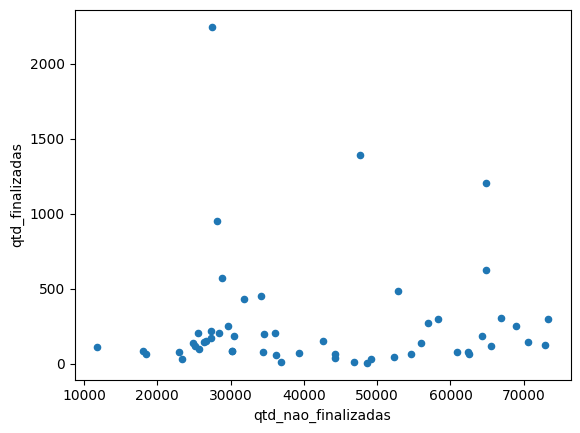

In [215]:
agregado.plot(x = 'qtd_nao_finalizadas', y = 'qtd_finalizadas', kind='scatter')

In [220]:
agregado

,data_f,ciclo_f,qtd_finalizadas,qtd_nao_finalizadas
0,2025-09-01,diurno,2248,27442
1,2025-09-01,noturno,1389,47618
2,2025-09-02,diurno,950,28088
3,2025-09-02,noturno,1202,64828
4,2025-09-03,diurno,431,31792
5,2025-09-03,noturno,481,52877
6,2025-09-04,diurno,569,28800
7,2025-09-04,noturno,623,64902
8,2025-09-05,diurno,449,34098
9,2025-09-05,noturno,295,58236


In [218]:
agregado.qtd_finalizadas.sum() / agregado.qtd_nao_finalizadas.sum()

0.006204595889389217